In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import scipy.spatial
import bordado as bd

In [2]:
def rolling_window_spherical(coordinates, window_size, overlap=0):
    region = bd.get_region(coordinates)
    window_step = (1 - overlap) * window_size
    bands = bd.line_coordinates(
        *region[2:], spacing=window_step, pixel_register=True, adjust="region",
    )
    latitude = []
    longitude = []
    indices1d = []
    data_indices = np.arange(coordinates[0].size)
    for central_latitude in bands:
        # Figure out the size in longitude that leads to equal area
        window_size_lon = window_size / np.cos(np.radians(central_latitude))
        window_step_lon = (1 - overlap) * window_size_lon
        # Generate the longitudes of window centers in this band.         
        # Always adjust the spacing to make sure windows are evenly distributed 
        # across the 360-0 boundary.
        band_longitude = bd.line_coordinates(*region[:2], spacing=window_step_lon, pixel_register=True, adjust="spacing")
        band_latitude = np.full_like(band_longitude, central_latitude)
        # Make a KD tree with points only in this band. This is needed because query_ball_point 
        # only works for "square" windows and we'd select too many points if using window_size_lon
        # (with points out of the latitude band) or too little if using window_size (since 
        # longitude intervals are larger).
        latitude_min = central_latitude - window_size / 2
        latitude_max = central_latitude + window_size / 2
        in_band = (coordinates[1].ravel() >= latitude_min) & (coordinates[1].ravel() <= latitude_max)
        tree = scipy.spatial.KDTree(np.transpose([c.ravel()[in_band] for c in coordinates]))
        in_band_indices = tree.query_ball_point(
                np.transpose([band_longitude, band_latitude]), r=window_size_lon / 2, p=np.inf,
        )
        band_indices1d = [data_indices[in_band][i] for i in in_band_indices]
        latitude.append(band_latitude)
        longitude.append(band_longitude)
        indices1d.extend(band_indices1d)
    # Join results from all bands
    latitude = np.concatenate(latitude)
    longitude = np.concatenate(longitude)
    centers = (longitude, latitude)
    # Make indices match shape of coordinates
    indices = np.empty(centers[0].shape, dtype="object")
    indices.ravel()[:] = [
        np.unravel_index(np.array(i, dtype="int"), shape=coordinates[0].shape)
        for i in indices1d
    ]
    return centers, indices

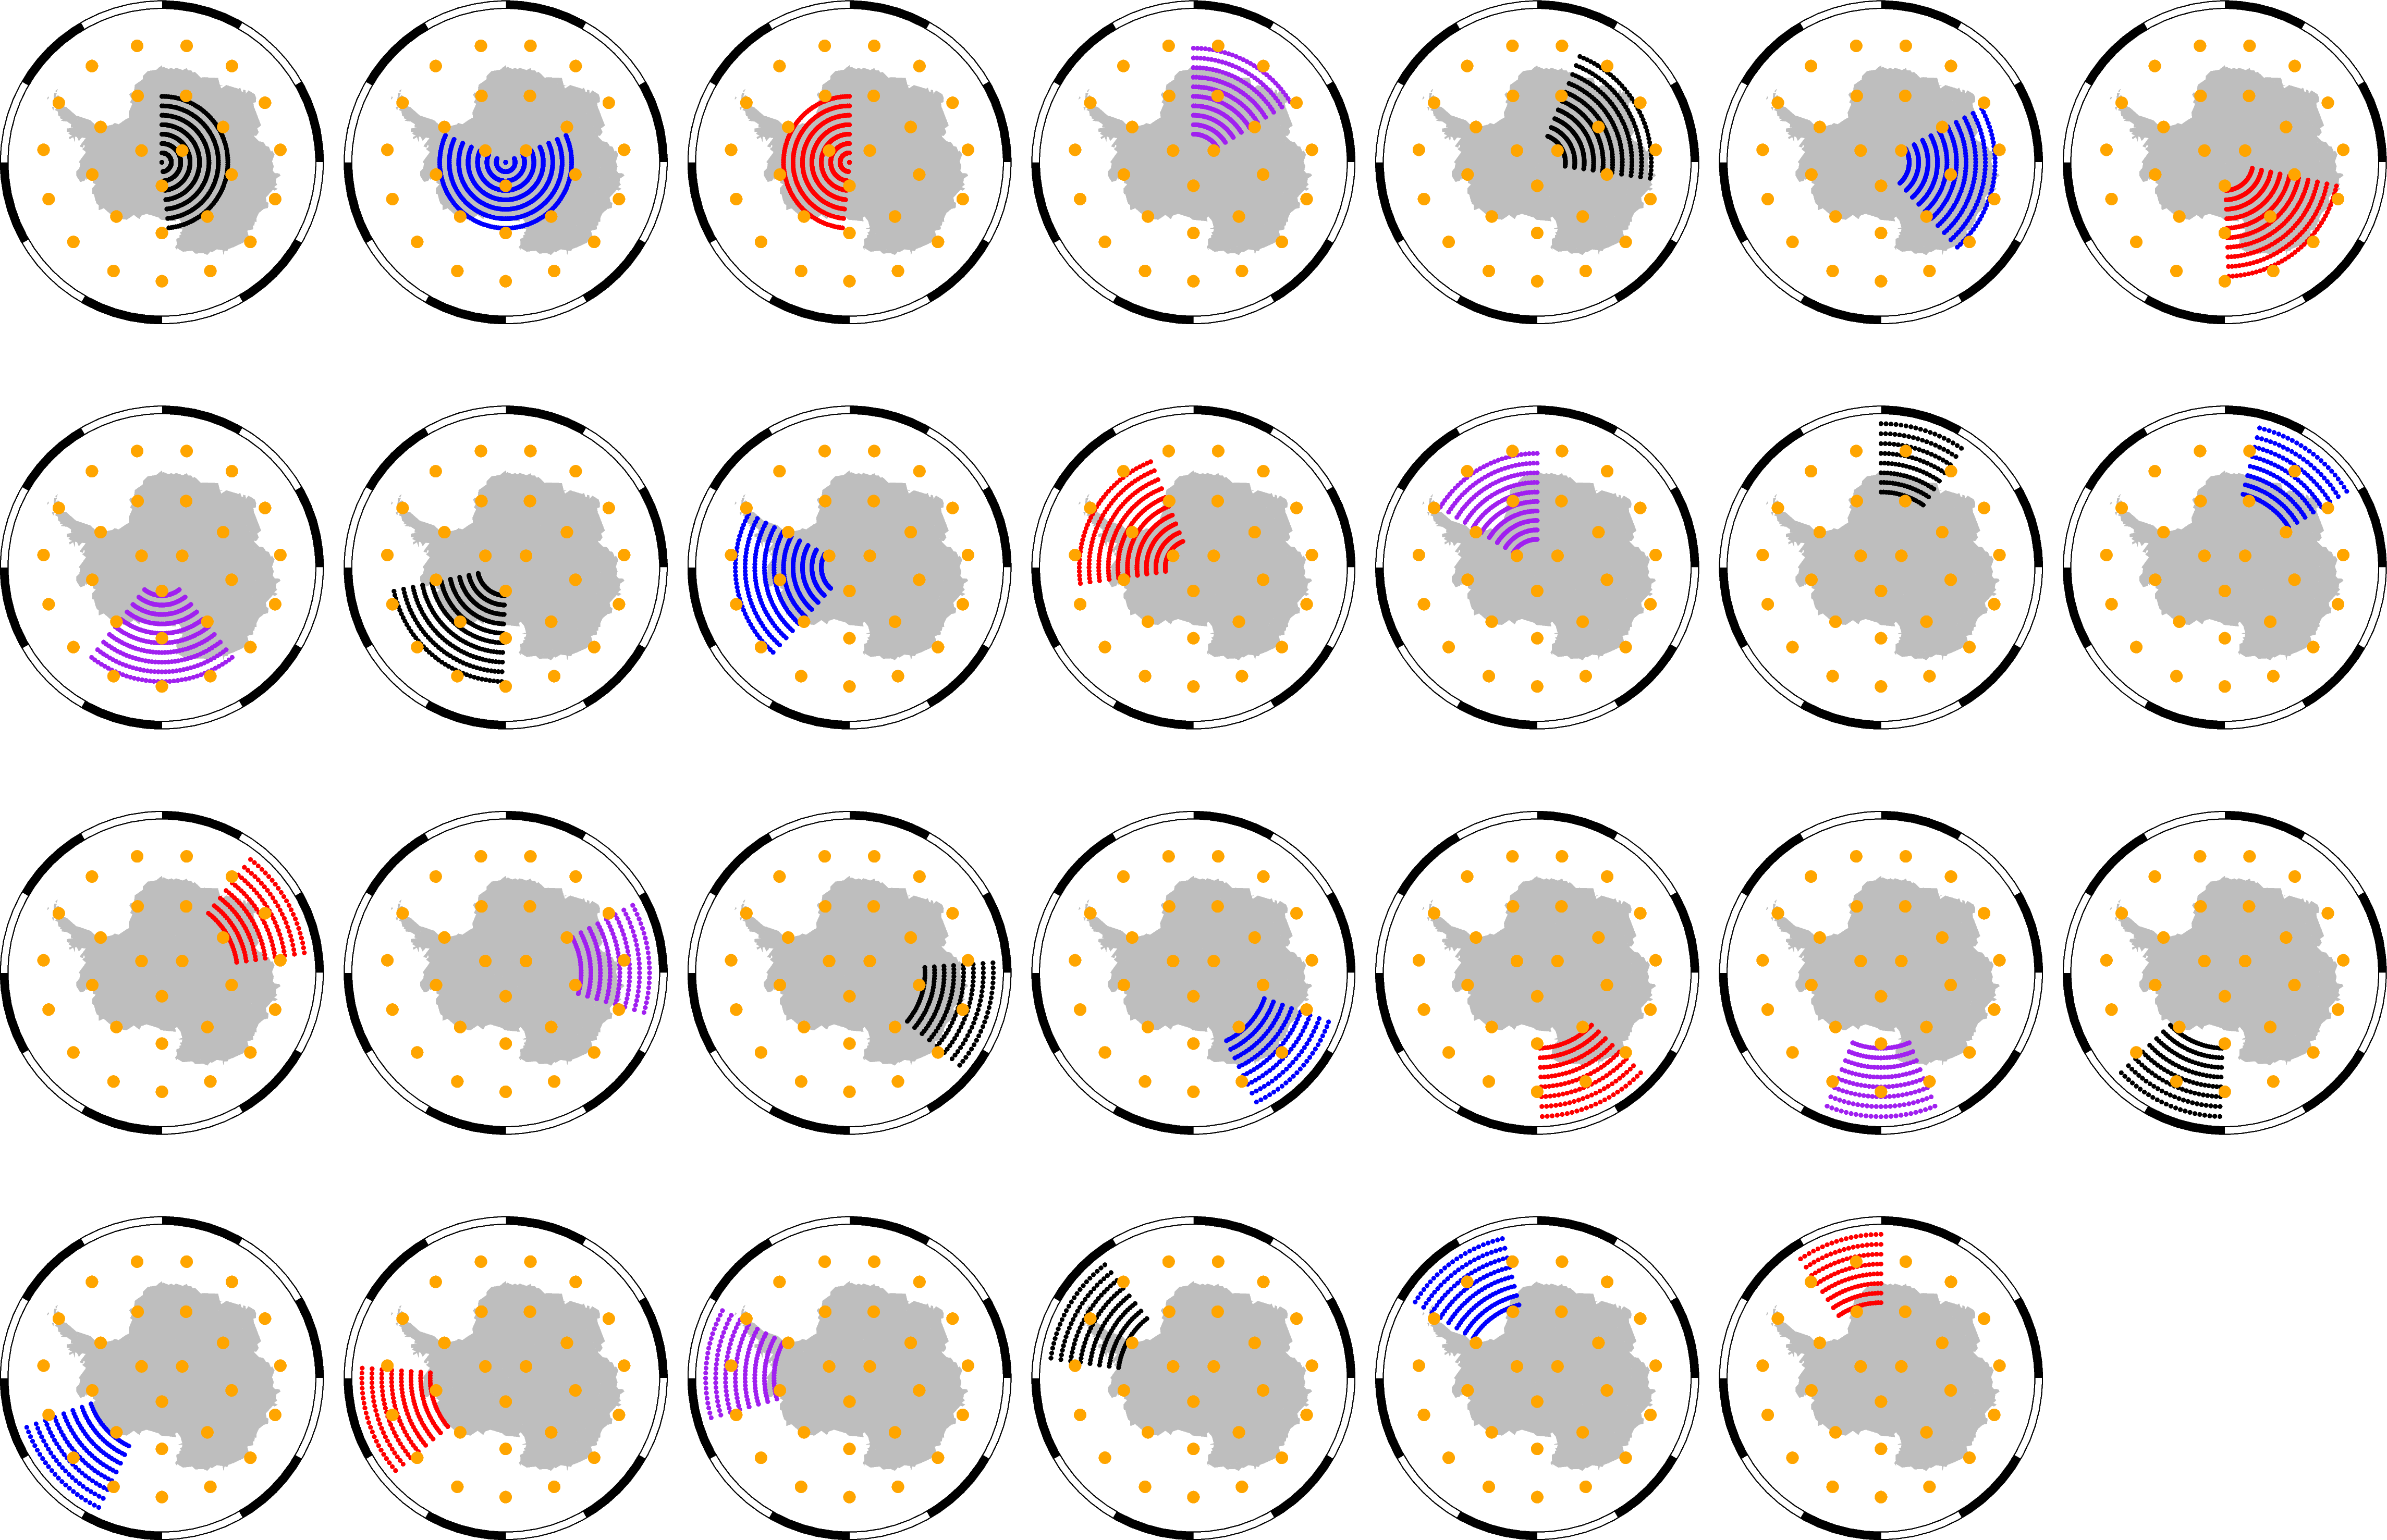

In [4]:
region = [0, 360, -90, -60]
coordinates = bd.grid_coordinates(region, spacing=2)
(longitude, latitude), indices = bd.rolling_window_spherical(coordinates, window_size=20, overlap=0.5)
colors = "black blue red purple".split() * 500
fig = pygmt.Figure()
ncols = 7
with fig.subplot(int(np.ceil(len(indices) / ncols)), ncols, subsize="5c/6c", margins=0):
    for p, (i, color) in enumerate(zip(indices, colors)):
        with fig.set_panel(p):
            fig.coast(land="gray", region=[0, 360, -90, -58], projection="S0/-90/?", frame="f")
            fig.plot(x=coordinates[0][i].ravel(), y=coordinates[1][i].ravel(), style="c0.07c", fill=color)
            fig.plot(x=longitude, y=latitude, style="c0.2c", fill="orange")
fig.show(width=1000)

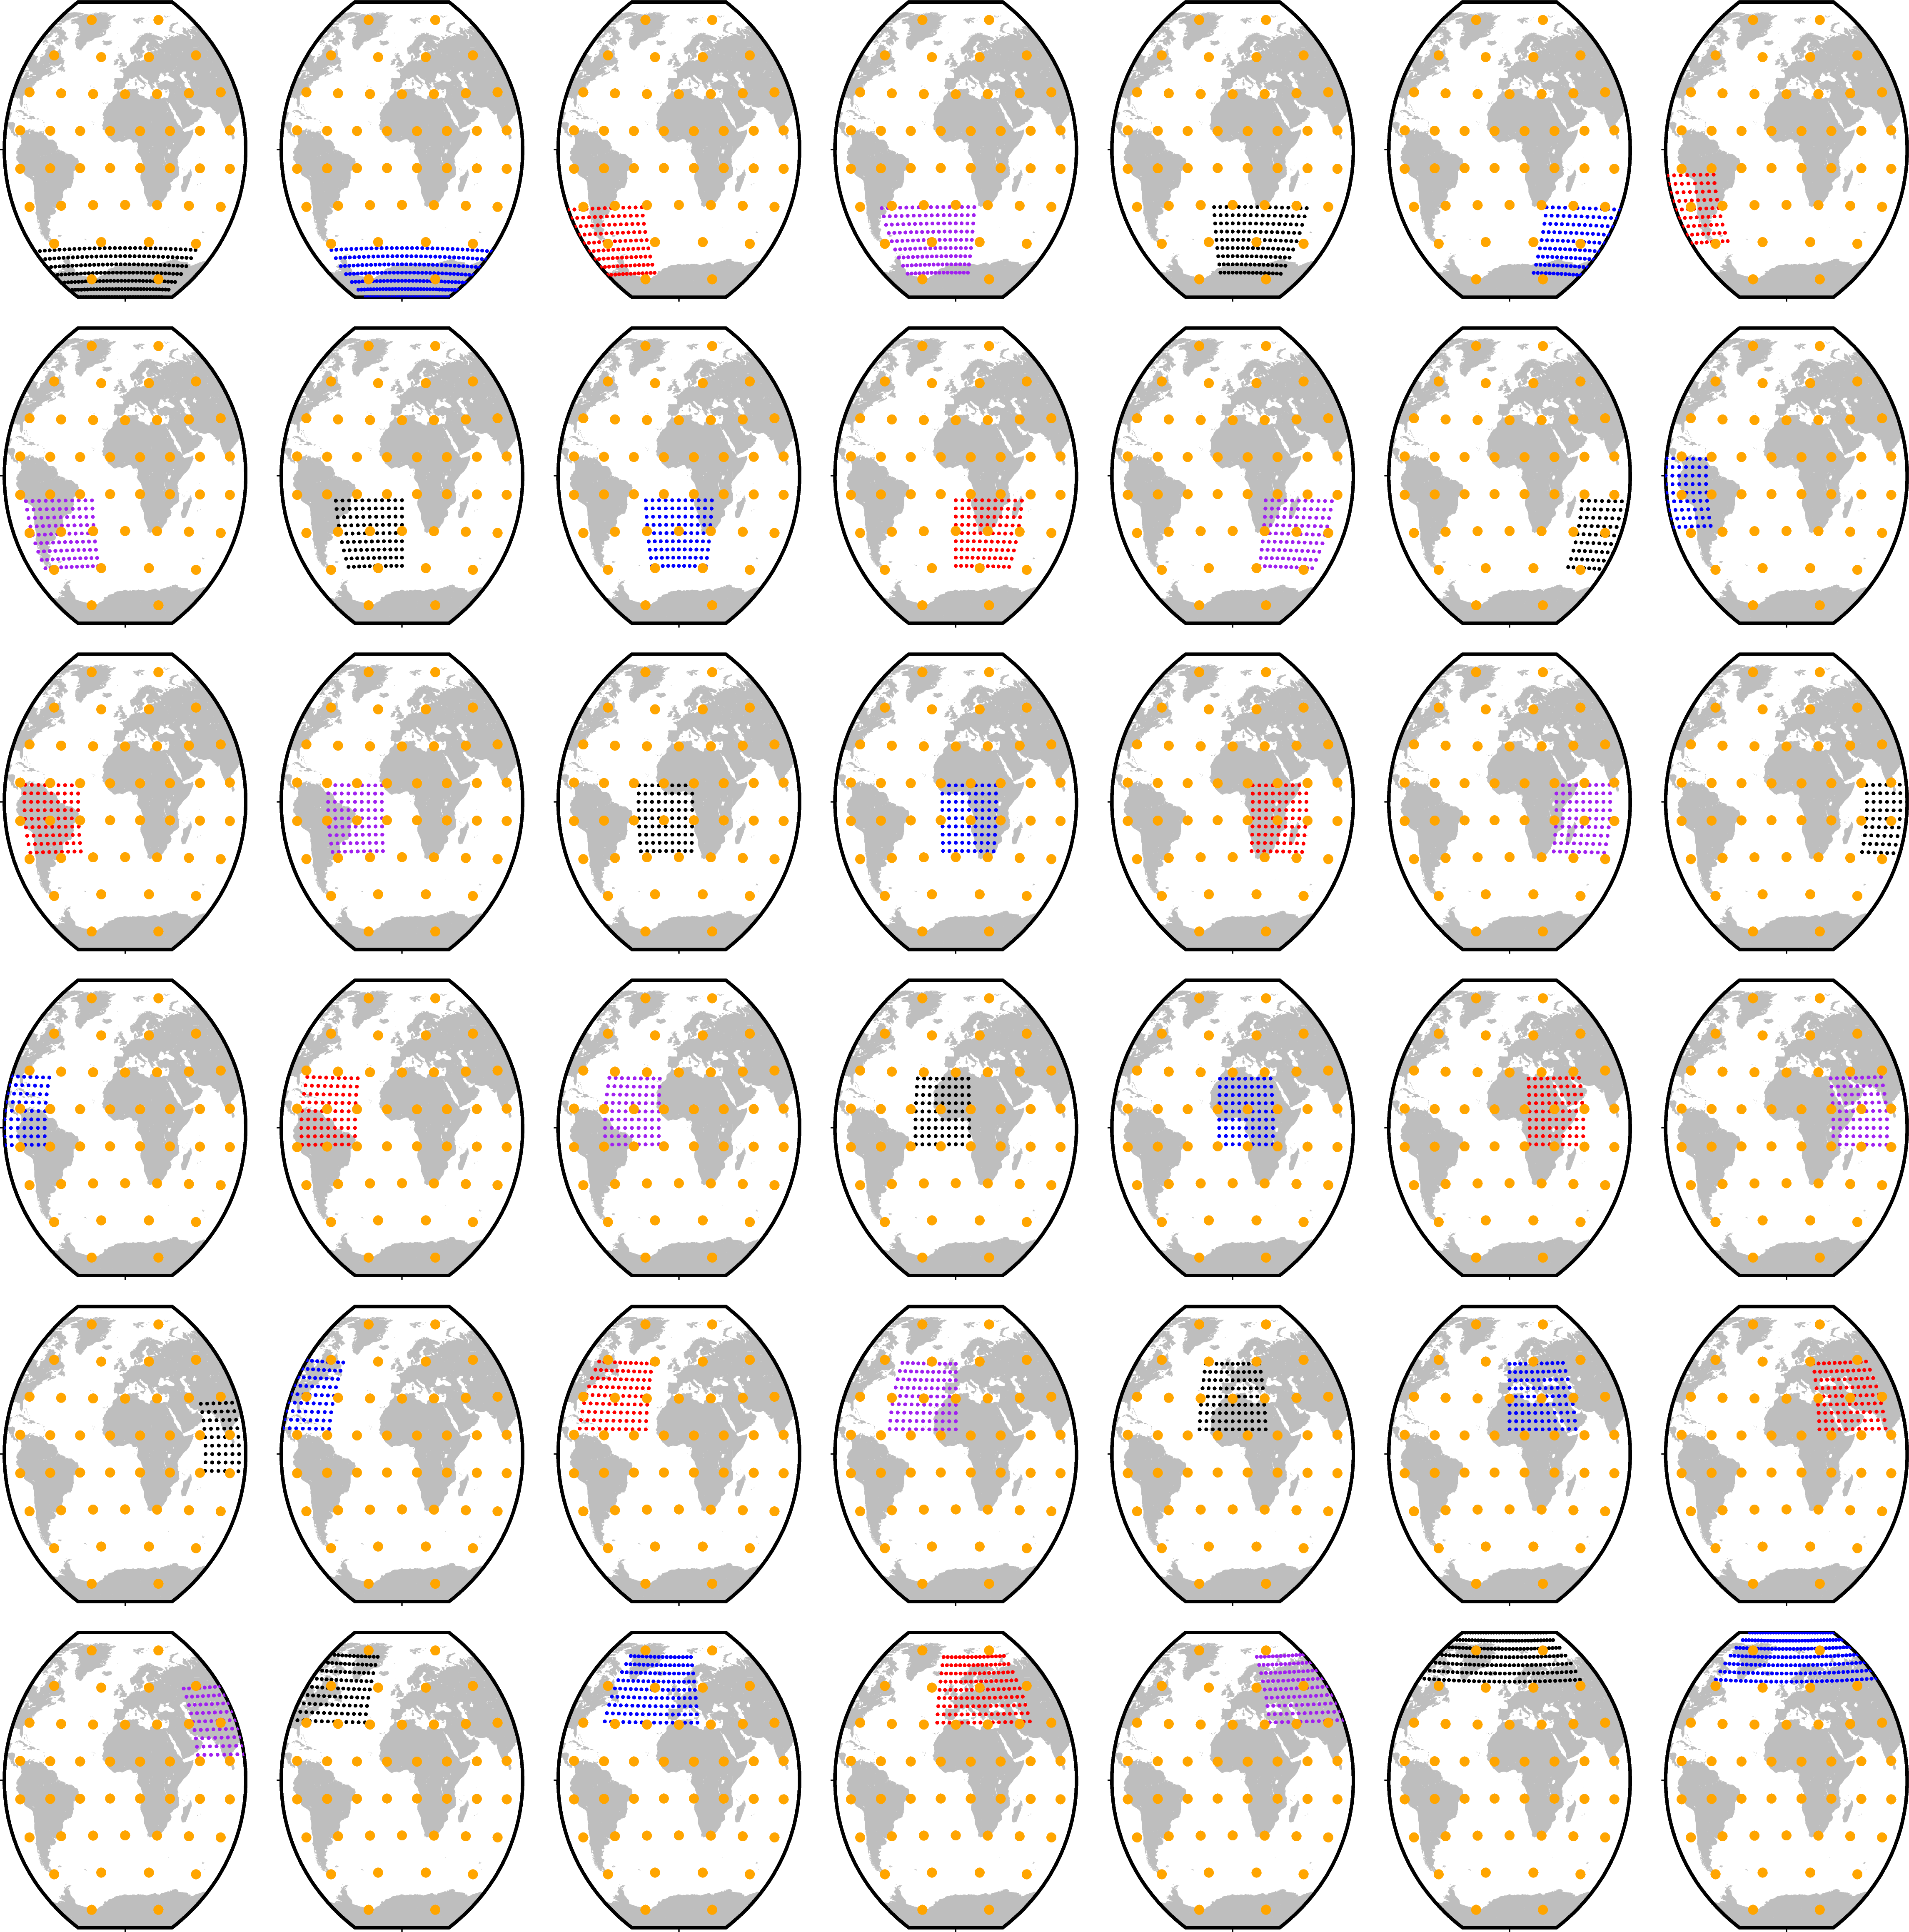

In [9]:
region = [-90, 90, -90, 90]
coordinates = bd.grid_coordinates(region, spacing=5)
(longitude, latitude), indices = rolling_window_spherical(coordinates, window_size=45, overlap=0.5)
colors = "black blue red purple".split() * 500
fig = pygmt.Figure()
ncols = 7
with fig.subplot(int(np.ceil(len(indices) / ncols)), ncols, subsize="5c/6c", margins=0):
    for p, (i, color) in enumerate(zip(indices, colors)):
        with fig.set_panel(p):
            fig.coast(land="gray", region=region, projection="R0/?", frame="f180")
            fig.plot(x=coordinates[0][i].ravel(), y=coordinates[1][i].ravel(), style="c0.07c", fill=color)
            fig.plot(x=longitude, y=latitude, style="c0.2c", fill="orange")
fig.show(width=1000)